Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import requests
import os

seed = 42

download = False	# Flag to download or create the graph from local file
graph_url = "https://github.com/SorenLKuhl/imdb_network/raw/refs/heads/main/imdb_movie_network.pkl"

# Download backboning script
bb_url = "https://raw.githubusercontent.com/SorenLKuhl/RockBandWikiData/refs/heads/main/backboning.txt"
bb_response = requests.get(bb_url)
bb_response.raise_for_status()
with open("backboning.py", 'w') as f:
    f.write(bb_response.text)

import backboning

We load the tsv containing the movies of interest.

In [5]:
if download:
	print("Do nothing for now - download graph from GitHub later")
else:
	path = "../datasets/final_filtered_movies_with_reviews.tsv"
	movies_df = pd.read_csv(path, sep="\t")
	print(f"Number of movies: {len(movies_df)}")
	print(movies_df.head())

Number of movies: 2638
      tconst                     primaryTitle  averageRating  numVotes  \
0  tt0012349                          The Kid            8.2    143593   
1  tt0013442  Nosferatu: A Symphony of Horror            7.8    121536   
2  tt0015864                    The Gold Rush            8.1    126386   
3  tt0017136                       Metropolis            8.3    197727   
4  tt0017925                      The General            8.1    104523   

                           originalTitle  \
0                                The Kid   
1  Nosferatu, eine Symphonie des Grauens   
2                          The Gold Rush   
3                             Metropolis   
4                            The General   

                                              nconst                   genres  \
0                    nm0001067, nm0588033, nm0701012      Comedy,Drama,Family   
1  nm0098774, nm0332024, nm0334603, nm0374594, nm...           Fantasy,Horror   
2  nm0074788, nm0354913,

Now we create an undirected networkx graph with the movies as nodes and actors as links. We save the accompanying data as attributes on the nodes.

In [7]:
if download:
	# Download the pickled graph from GitHub
	response = requests.get(graph_url)
	response.raise_for_status()  # Ensure we got a successful response
	G = pickle.loads(response.content)
else:
	G: nx.Graph = nx.Graph()	# Undirected as links are actors in common

	# Create mapping of actors to movies
	actor_to_movies = {}

	for idx, row in movies_df.iterrows():

		# Add movie as node with attributes
		id = row['tconst']
		title = row['primaryTitle']
		original_title = row['originalTitle']
		avg_rating = row['averageRating']
		num_ratings = row['numVotes']
		actors = row['nconst'].split(', ') if 'nconst' in row and pd.notna(row['nconst']) else []
		reviews = row['top20_reviews'].split('|||') if 'top20_reviews' in row and pd.notna(row['top20_reviews']) else []
		genres = row['genres'].split(', ') if 'genres' in row and pd.notna(row['genres']) else []
		G.add_node(id, title=title, original_title=original_title, avg_rating=avg_rating, num_ratings=num_ratings, reviews=reviews, genres=genres, actors=actors)

		# Map actors to movies
		for actor in actors:
			if actor not in actor_to_movies:
				actor_to_movies[actor] = []
			actor_to_movies[actor].append(id)

	# Add edges based on shared actors
	for actor, movies in actor_to_movies.items():
		for i in range(len(movies)):
			for j in range(i + 1, len(movies)):
				# check if edge already exists, if so, append actor to list
				if G.has_edge(movies[i], movies[j]):
					G[movies[i]][movies[j]]['actors'].append(actor)
					G[movies[i]][movies[j]]['weight'] = len(G[movies[i]][movies[j]]['actors'])
				else:
					G.add_edge(movies[i], movies[j], actors=[actor], weight=1)

# Display basic info about the graph - should have num of node = num of movies
print(G)

Graph with 2638 nodes and 29738 edges


To ensure the mapping works as intended, we check the movies that are linked by Leonardo DiCaprio to see if the list is as expected.

In [12]:
test_name = "Willem Dafoe"
linked_movies = set()
for movie1, movie2, data in G.edges(data=True):
	if test_name in data['actors']:
		linked_movies.add(G.nodes[movie1]['title'])
		linked_movies.add(G.nodes[movie2]['title'])
print(f"Movies linked by {test_name}: {linked_movies}")

Movies linked by Willem Dafoe: set()


We add genres from updated file

In [5]:
if not download:
	path = "../datasets/final_filtered_movies_with_actor_ids.tsv"
	movies_df = pd.read_csv(path, sep="\t")
	print(f"Number of movies: {len(movies_df)}")
	print(movies_df.head())

Number of movies: 2638
      tconst                     primaryTitle  averageRating  numVotes  \
0  tt0012349                          The Kid            8.2    143593   
1  tt0013442  Nosferatu: A Symphony of Horror            7.8    121536   
2  tt0015864                    The Gold Rush            8.1    126386   
3  tt0017136                       Metropolis            8.3    197727   
4  tt0017925                      The General            8.1    104523   

                           originalTitle  \
0                                The Kid   
1  Nosferatu, eine Symphonie des Grauens   
2                          The Gold Rush   
3                             Metropolis   
4                            The General   

                                              nconst                   genres  
0                    nm0001067, nm0588033, nm0701012      Comedy,Drama,Family  
1  nm0098774, nm0332024, nm0334603, nm0374594, nm...           Fantasy,Horror  
2  nm0074788, nm0354913, nm

In [6]:
if not download:
    for idx, row in movies_df.iterrows():
        id = row["tconst"]
        genres = row["genres"].split(', ') if 'genres' in row and pd.notna(row['genres']) else []
        G.nodes[id]["genres"] = genres

# test genres 
for movie in list(G.nodes)[:5]:
    print(f"Movie: {G.nodes[movie]['title']}, Genres: {G.nodes[movie]['genres']}")

Movie: The Kid, Genres: ['Comedy,Drama,Family']
Movie: Nosferatu: A Symphony of Horror, Genres: ['Fantasy,Horror']
Movie: The Gold Rush, Genres: ['Adventure,Comedy,Drama']
Movie: Metropolis, Genres: ['Drama,Sci-Fi']
Movie: The General, Genres: ['Action,Adventure,Comedy']


We add actor ids from new file

In [ ]:
# replace actor names with actor ids in edges and nodes
# actor_id_to_movie_id = {}
# if not download:
# 	for idx, row in movies_df.iterrows():
# 		id = row["tconst"]
# 		actor_ids = row["nconst"].split(', ') if 'nconst' in row and pd.notna(row['nconst']) else []
# 		G.nodes[id]["actor_ids"] = actor_ids
# 		# Remove actor names from nodes
# 		del G.nodes[id]["actors"]
# 		# Update mapping
# 		for actor_id in actor_ids:
# 			if actor_id not in actor_id_to_movie_id.keys():
# 				actor_id_to_movie_id[actor_id] = []
# 			actor_id_to_movie_id[actor_id].append(id)

# 	# Update edges to use actor ids instead of names
# 	# Remove all edges
# 	G.remove_edges_from(list(G.edges))
# 	# Re-add edges based on actor ids
# 	for actor_id, movies in actor_id_to_movie_id.items():
# 		for i in range(len(movies)):
# 			for j in range(i + 1, len(movies)):
# 				# check if edge already exists, if so, append actor_id to list
# 				if G.has_edge(movies[i], movies[j]):
# 					G[movies[i]][movies[j]]['actor_ids'].append(actor_id)
# 					G[movies[i]][movies[j]]['weight'] = len(G[movies[i]][movies[j]]['actor_ids'])
# 				else:
# 					G.add_edge(movies[i], movies[j], actor_ids=[actor_id], weight=1)

# print(G)


Graph with 2638 nodes and 29738 edges


Pickle G to upload to GitHub for easy download from other devices.

In [8]:
if not download:
	pickle_path = "imdb_movie_network.pkl"
	with open(pickle_path, 'wb') as f:
		pickle.dump(G, f)

We see that only 4 movies are found, which makes sense as the "actors" field of the data is created from the actor's "known for" movies on imdb which is max 4.

We now extract the network backbone:

In [9]:
# We use the weight attribute (number of shared actors) to extract the backbone of the network
# Convert graph to pd dataframe
edge_data = nx.to_pandas_edgelist(G, source='src', target='trg')
# Store in file
edge_data.to_csv("edge_data.csv", sep='\t')
# load from file
table, num_nodes, num_edges = backboning.read("edge_data.csv","weight")
# noise correction
nc_table = backboning.noise_corrected(table)
# extract backbone
bb_table = backboning.thresholding(nc_table, 98.0)
print(f"Backbone has {bb_table.shape[0]} edges out of {table.shape[0]} total edges.")

Calculating NC score...


Backbone has 14064 edges out of 29738 total edges.


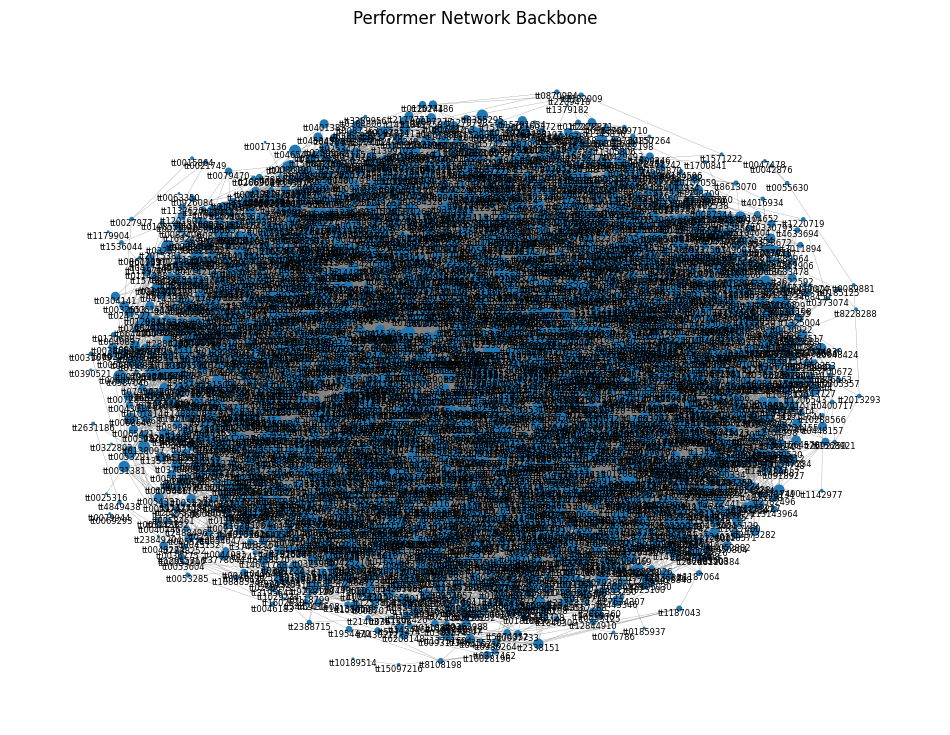

In [10]:
# Create backbone graph
bb_graph = nx.from_pandas_edgelist(bb_table, source='src', target='trg', edge_attr='nij')

# Ensure nice layout
pos = nx.forceatlas2_layout(bb_graph, max_iter=100, jitter_tolerance=0.5, scaling_ratio=1.0, gravity=1.0, strong_gravity=True, seed=seed)

# Use degree for node sizes
node_sizes = [bb_graph.degree[n]**1.5 for n in bb_graph.nodes()]

plt.figure(figsize=(12, 9))
# Firstly, draw the node interactivily
nodes = nx.draw_networkx_nodes(bb_graph, pos,node_size=node_sizes)
# Secondly, draw the edges
nx.draw_networkx_edges(bb_graph, pos, edge_color="gray", width=0.2)
# Thirdly, add labels to larger nodes
# labels = {n: n for n in bb_graph.nodes() if bb_graph.degree[n] > 8}
nx.draw_networkx_labels(bb_graph, pos, font_size=6, verticalalignment='top')

plt.title("Performer Network Backbone")
plt.axis("off")
plt.show()